# Daily step count and average monthly temperature in Iowa

In [1]:
import xml.etree.ElementTree
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from calendar import monthrange
FS = 16 # Font size for plots

### Load the Apple health data (step counts)

In [4]:
def load_apple_health_data(pathToFile, item_type_identifier='HKQuantityTypeIdentifierStepCount'):
    # Reads the XML file exported by Apple's Health iOS app
    xDoc = xml.etree.ElementTree.parse(pathToFile)
    items = list(xDoc.getroot()) # Elements in the XML data file
    
    # Loop through the XML items, appending samples with the requested identifier
    all_types = []
    tmp_data = []
    for i,item in enumerate(items):
        if 'type' in item.attrib and item.attrib['type'] == item_type_identifier:
            tmp_data.append((item.attrib['creationDate'],
                             item.attrib['startDate'],
                             item.attrib['endDate'],
                             item.attrib['value']))

    # Convert to data frame
    data = pd.DataFrame(tmp_data, columns = ['creationDate','startDate','endDate','steps'])
    return data, np.array(data.values[:,-1], dtype=int)

In [5]:
all_step_data, all_step_counts = load_apple_health_data('./data/apple_health_export/export.xml')
all_step_data.head()

,creationDate,startDate,endDate,steps
0,2017-05-20 14:04:32 -0500,2017-05-20 13:43:41 -0500,2017-05-20 13:50:53 -0500,29
1,2017-05-20 15:02:38 -0500,2017-05-20 13:59:30 -0500,2017-05-20 14:06:11 -0500,19
2,2017-05-20 15:02:38 -0500,2017-05-20 14:12:05 -0500,2017-05-20 14:19:39 -0500,50
3,2017-05-20 15:02:38 -0500,2017-05-20 14:19:39 -0500,2017-05-20 14:25:36 -0500,13
4,2017-05-20 15:02:38 -0500,2017-05-20 14:39:32 -0500,2017-05-20 14:45:32 -0500,5


### Plot the raw step count data

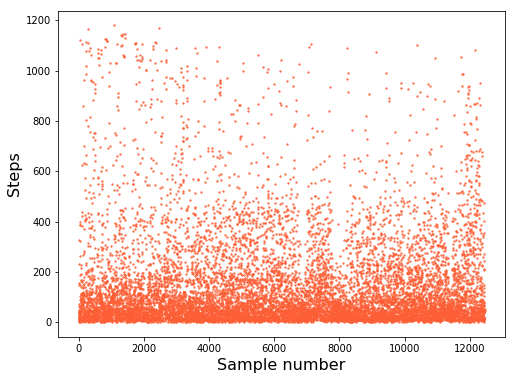

In [10]:
c = "#FC5F36"
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(all_step_counts, '.', color=c, markersize=3, alpha=0.7)
ax.set_xlabel("Sample number", fontsize=FS)
ax.set_ylabel("Steps", fontsize=FS)
# [ax.spines[loc].set_visible(False) for loc in ['right','top']]

plt.show()
# fig.savefig("./figures/step_counts_raw.png", format='png', dpi=300, bbox_inches='tight')

### Sum up step counts by day

In [30]:
steps_per_month, month_labels = [],[]
all_step_dates = all_step_data.creationDate.values
current_month = datetime.strptime(all_step_dates[0][:7], '%Y-%m')
running_step_count = 0
for n, (date, step_count) in enumerate(zip(all_step_dates, all_step_counts)):
    new_month = datetime.strptime(date[:7], '%Y-%m')
    if new_month > current_month or n == len(all_step_dates)-1:
        # How many days are in the current month?
        if date == all_step_dates[-1]:
            days_in_month = int(date[8:10])
        else:
            days_in_month = monthrange(current_month.year, current_month.month)[1]

        # Average step count for current month
        steps_per_month.append(running_step_count / days_in_month)
        month_labels.append(current_month.strftime('%b-%Y'))
        
        # Reset the running step count and current month
        current_month = new_month
        running_step_count = step_count
    else:
        running_step_count += step_count

# Convert to numpy arrays        
steps_per_month = np.array(steps_per_month)
month_labels = np.array(month_labels)

### Plot the daily average step count by month

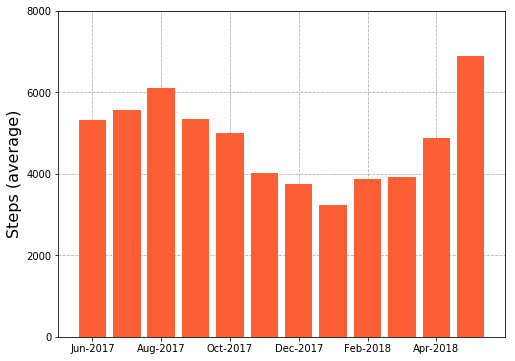

In [28]:
y = steps_per_month[1:]
x = np.arange(len(y))
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x, y, color=c, joinstyle="round")
ax.set_ylim((0,8000))
ax.set_ylabel("Steps (average)", fontsize=FS)
ax.set_yticks(np.arange(0,ax.get_ylim()[1]+1,2000))
ax.set_xticks(x[0:-1:2])
ax.set_xticklabels(month_labels[1:-1:2])
ax.grid(ls='dashed')
ax.set_axisbelow(True)
plt.show()
# fig.savefig("./figures/step_counts_monthly.png", format='png', dpi=300, bbox_inches='tight')

## Scrape some weather data

In [134]:
import requests
from bs4 import BeautifulSoup

In [208]:
def scrape_page_for_temperature(URL):
    # Scrape temperatures -- doesn't actually work, website requires clicking :(
    page = requests.get(URL)
    html = BeautifulSoup(page.text, "html.parser")
    avg_temp_row = html.find("div", class_="right_column").find_all("tr")[2]
    return float(avg_temp_row.find_all('td')[1].contents[0].split('°F')[0])

In [210]:
monthly_temps = []
for year in ['2017','2018']:
    for month in range(1,13):
        print("{y}-{m}".format(y=year,m=month))
        url = "https://www.usclimatedata.com/climate/iowa-city/iowa/united-states/usia0414/{y}/{m}".format(
            y=year,m=month)
        if (year is '2018' and month > 5) or (year is '2017' and month < 6):
            pass
        else:
            monthly_temps.append(scrape_page_for_temperature(url))

# convert to numpy array
monthly_temps = np.array(monthly_temps)

In [227]:
# https://www.usclimatedata.com/climate/iowa-city/iowa/united-states/usia0414/2017/11
monthly_temps = np.array([70.95,72.85,67.35,66.5,54.35,36.4,25.55,18.3,22.25,33.2,38.15])

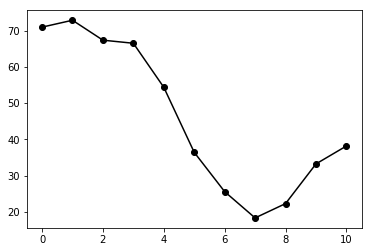

In [228]:
plt.plot(monthly_temps,'ko-')
plt.show()

## Load the weather data

In [126]:
# https://www.ncdc.noaa.gov/cag/city/time-series/USW00094910/tavg/all/4/2016-2018?base_prd=true&firstbaseyear=1901&lastbaseyear=2000
# https://www.usclimatedata.com/climate/iowa-city/iowa/united-states/usia0414/2017/2
filename = './data/AverageTemp_Waterloo_IA.csv'
temperature = np.genfromtxt(filename, delimiter=',', skip_header=5)
temperature = temperature[:,:3]
fun_format_date = lambda d: datetime.strptime(str(int(d)),'%Y%m').strftime('%b-%Y')
months_weather = list(map(fun_format_date, temperature[:,0]))

### Plot the weather data

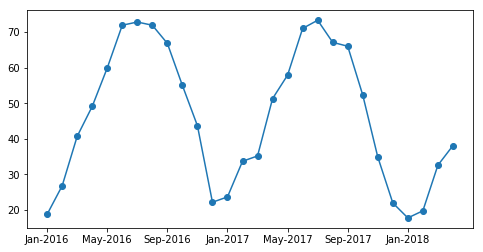

In [127]:
y = temperature[:,1]
x = np.arange(len(y))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x, y, 'o-')
ax.set_xticks(x[0:-1:4])
ax.set_xticklabels(months_weather[0:-1:4])
plt.show()

# Combine the steps and weather data in one plot

In [ ]:
months_steps = month_labels

In [221]:
# Find the overlapping indices
mask_months_weather = np.in1d(months_weather, months_steps)
mask_months_steps = np.in1d(months_steps, months_weather)

# Months that are common to both sources of data
months_both = np.intersect1d(months_weather, months_steps)
months_both

array(['Apr-2018', 'Aug-2017', 'Dec-2017', 'Feb-2018', 'Jan-2018',
       'Jul-2017', 'Jun-2017', 'Mar-2018', 'May-2017', 'Nov-2017',
       'Oct-2017', 'Sep-2017'], dtype='<U8')

In [229]:
# Specify the X and Y data for the plot
months_both = months_steps[mask_months_steps][1:]
y_step = steps_per_month[mask_months_steps][1:]
# y_temp = temperature[mask_months_weather,1][1:]
y_temp = monthly_temps
x = np.arange(len(y_step))

### Make the combined plot

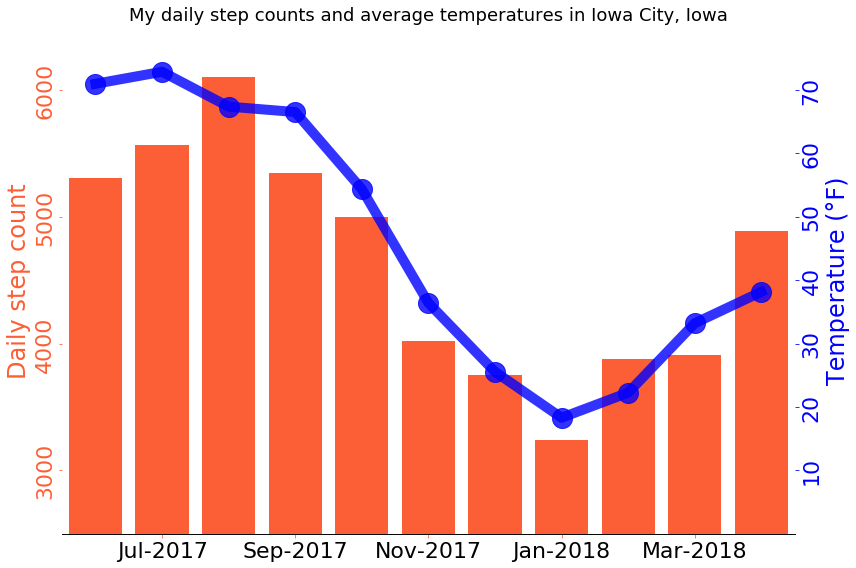

In [265]:
c1, c2 = c, 'blue'
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax1.bar(x, y_step, color=c1, label='Steps', alpha=1)
ax2.plot(x, y_temp, 'o-', color=c2, lw=10, ms=20, alpha=0.8, label='Weather')

ax1.set_xticks(x[1:-1:2])
ax1.set_xticklabels(months_both[1:-1:2])

ax1.set_ylim((2500,6500))
ax1.set_yticks(np.arange(3000,6001,1000))
ax2.set_ylim((0,80))
ax2.set_yticks(np.arange(10,71,10))


# Increase tick label font sizes
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_color(c1)
    tick.label.set_rotation('vertical')
    tick.label.set_verticalalignment('center')
for tick in ax2.yaxis.get_major_ticks():
    tick.label2.set_rotation('vertical')
    tick.label2.set_verticalalignment('center')
    
ax1.set_ylabel("Daily step count",   fontsize=FS+8, color=c1)
ax2.set_ylabel("Temperature (°F)", fontsize=FS+8, color=c2)

ax1.tick_params(labelsize=FS+6, color=c1)
ax2.tick_params(labelsize=FS+6, labelcolor=c2, color=c2)

for ax in [ax1,ax2]:
    [ax.spines[spine].set_visible(False) for spine in ['top','left','right']]
    
ax1.set_xlim((-0.5,10.5))    

ax1.set_title("My daily step counts and average temperatures in Iowa City, Iowa", fontsize=FS+2)
# ax2.grid(axis='y', alpha=0.75, ls='dashed')
# ax2.set_axisbelow(True)

fig.tight_layout()
plt.savefig("./figures/temperature_and_step_count.png", format='png', dpi=300)
# plt.show()

### Steps as a function of temperature

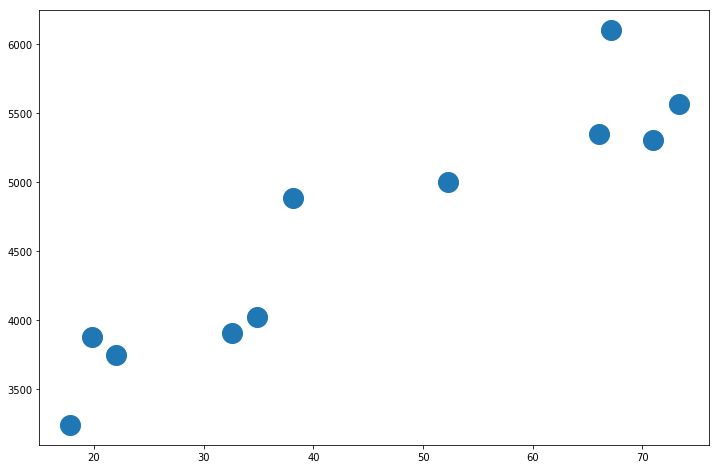

In [42]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(y_temp, y_step, 'o', ms=20)
plt.show()